In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
trees = pd.read_csv("trees.csv")
trees = trees.drop(["Unnamed: 0"], axis=1)
trees.head()

,Girth,Height,Volume
0,8.3,70,10.3
1,8.6,65,10.3
2,8.8,63,10.2
3,10.5,72,16.4
4,10.7,81,18.8


In [3]:
trees.tail()

,Girth,Height,Volume
26,17.5,82,55.7
27,17.9,80,58.3
28,18.0,80,51.5
29,18.0,80,51.0
30,20.6,87,77.0


In [4]:
girth = np.array(trees["Girth"]).reshape(len(trees), 1)
height = np.array(trees["Height"]).reshape(len(trees), 1)
volume = np.array(trees["Volume"]).reshape(len(trees), 1)

In [5]:
Z = np.hstack([girth, height])
Z.shape

(31, 2)

In [6]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(Z, volume)
coefficients = reg.coef_
intercept = reg.intercept_
print(coefficients.shape)
print(intercept.shape)

(1, 2)
(1,)


In [7]:
coefficients, intercept

(array([[4.7081605 , 0.33925123]]), array([-57.98765892]))

In [8]:
# Least square estimator
estimator = np.matmul(Z, coefficients.T) + intercept
estimator.shape

(31, 1)

In [9]:
# Fitted response value
estimator[-1]

array([68.51530482])

In [10]:
epsilon = volume - estimator

N = len(volume)
r = 2
dof = N-r-1

sq_s = np.matmul(epsilon.T, epsilon)
sq_s /= dof

t = 2.048 #t for 0.05/2

inverse = np.linalg.inv(np.matmul(Z.T, Z))

H = np.matmul(Z, inverse)
H = np.matmul(H, Z.T)

In [11]:
z1 = np.array([15, 70]).T
z2 = np.array([20, 80]).T

estimator1 = np.matmul(z1, coefficients.T) + intercept
estimator2 = np.matmul(z2, coefficients.T) + intercept

In [12]:
def get_interval(dof, z, estimator):
    interval = np.matmul(z.T, inverse)
    interval = np.matmul(interval, z)
    interval += 1
    interval *= sq_s
    interval = interval**0.5
    interval *= t
    
    lower = estimator - interval
    upper = estimator + interval
    return lower, upper


print(get_interval(dof, z1, estimator1))
print(get_interval(dof, z2, estimator2))

(array([[28.19270318]]), array([[44.57196686]]))
(array([[54.61806072]]), array([[72.01323905]]))


In [13]:
trees.iloc[-1]

Girth     20.6
Height    87.0
Volume    77.0
Name: 30, dtype: float64

In [14]:
studentized = []
for i in range(len(volume)):
    numerator = epsilon[i]
    denominator = sq_s*(1-H[i][i])
    denominator = denominator ** 0.5
    studentized.append(float(numerator/denominator))
len(studentized)

31

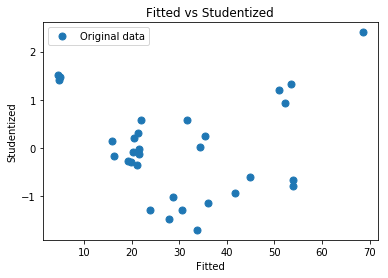

In [15]:
plt.plot(estimator, studentized, 'o', label='Original data', markersize=7)
plt.xlabel("Fitted")
plt.ylabel("Studentized")
plt.title("Fitted vs Studentized")
plt.legend()
plt.show()

In [16]:
# Largest absolute studentized residuals
np.abs(studentized).max(), studentized.index(np.abs(studentized).max())

(2.4015128102811873, 30)

In [17]:
# Leverages
leverages = [H[i][i] for i in range(len(volume))]
np.max(leverages), leverages.index(np.max(leverages))

(0.17162078516631085, 30)

In [18]:
trees.iloc[30]

Girth     20.6
Height    87.0
Volume    77.0
Name: 30, dtype: float64

In [19]:
# Fitted response value
estimator[-1]

array([68.51530482])

In [20]:
Z2 = np.hstack([girth, girth**2, height])
reg2 = LinearRegression().fit(Z2, volume)
coefficients2 = reg2.coef_
intercepts2 = reg2.intercept_
print(coefficients2.shape)
print(intercepts2.shape)

(1, 3)
(1,)


In [21]:
est2 = np.matmul(Z2, coefficients2.T) + intercepts2
est2.shape

(31, 1)

In [22]:
import statistics as stats
import scipy.stats as ss

def Ftest_pvalue(d1,d2):
    
    df1 = len(d1) - 1
    df2 = len(d2) - 1
    F = np.var(d1) / np.var(d2)
    print("F",F)
    single_tailed_pval = ss.f.cdf(F,df1,df2)
    double_tailed_pval = single_tailed_pval * 2
    print("P", 1-single_tailed_pval)
#     return F, 1-single_tailed_pval

In [23]:
Ftest_pvalue(estimator, est2)

F 0.9702137139949881
P 0.5327259448915067


Choose the original model.

In [25]:
Z3 = np.log(Z)
reg3 = LinearRegression().fit(Z3, np.log(volume))
coefficients3 = reg3.coef_
intercept3 = reg3.intercept_
print(coefficients3.shape)
print(intercept3.shape)


(1, 2)
(1,)


In [26]:
log_est = np.matmul(Z3, coefficients3.T) + intercept3
# np.hstack([log_est, np.log(volume)])

In [27]:
Ftest_pvalue(estimator, log_est)

F 945.9495978151089
P 1.1102230246251565e-16
